## Stock Price Prediction (NIFTY 50)

### Assignment

- High
- KNN,RNN,GRU,LSTM,Bidirectional (50 Epochs)
- 30,60,90

### Assignment Documentation

Based on the analysis performed in this notebook, the assignment is to focus on building and evaluating models for predicting the **High** price of the NIFTY 50 index.

Specifically, you should concentrate on the following models and time windows:

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

*   **Time Windows (Input Days):**
    *   30 days
    *   60 days
    *   90 days

For the Deep Learning models (RNN, GRU, LSTM, Bidirectional LSTM), train them for **50 epochs**.

The goal is to train these specific models for the 'High' column using the specified time windows and evaluate their performance using MAE and RMSE, comparing the results.

In [41]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Data.csv')
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,31-OCT-2025,25863.80,25953.75,25711.20,25722.10,334384400,28788.40
1,30-OCT-2025,25984.40,26032.05,25845.25,25877.85,257373001,24180.46
2,29-OCT-2025,25982.00,26097.85,25960.30,26053.90,321880610,26309.32
3,28-OCT-2025,25939.95,26041.70,25810.05,25936.20,395231207,37023.32
4,27-OCT-2025,25843.20,26005.95,25827.00,25966.05,266337274,23989.06


### 2. Data Preparation

1. **Train-Test Split**
   - `train_test_split()` → split data into training & testing sets.  

2. **Models List**
   - A collection of regressors:  
     - Linear: `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based: `RandomForestRegressor`, `GradientBoostingRegressor`  
     - Others: `SVR`, `KNeighborsRegressor`, `XGBRegressor`, `LGBMRegressor`  

3. **Training Loop**
   - For each model:  
     - `fit()` → train on training data  
     - `predict()` → generate predictions on test data  

4. **Evaluation**
   - Metrics used:  
     - `mean_absolute_error`  
     - `mean_squared_error`  
   - Store results for comparison of all models.  

In [42]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns =  ['Open', 'Close', 'High', 'Low']
day_chunks =  [30, 60, 90]

chunked_data = {}

# Strip whitespace from column names
df.columns = df.columns.str.strip()

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

### 3. Define Neural Network Models

1. **Imports**
   - `Sequential` → build models layer-by-layer  
   - Layers: `Dense`, `SimpleRNN`, `LSTM`, `GRU`, `Bidirectional`  

2. **Model Builder Functions**
   - `build_rnn(input_shape)`  
     - Simple RNN with 50 units → `Dense(1)` output  
   - `build_lstm(input_shape)`  
     - LSTM with 50 units → `Dense(1)` output  
   - `build_gru(input_shape)`  
     - GRU with 50 units → `Dense(1)` output  
   - `build_bilstm(input_shape)`  
     - Bidirectional LSTM with 50 units → `Dense(1)` output  

3. **Compilation**
   - Optimizer: `adam`  
   - Loss: `mse` (Mean Squared Error)  

4. **Purpose**
   - All models → designed for **regression tasks on sequential data**.  

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### 4. Define ML Models

1. **ml_models (Traditional ML)**
   - A list of tuples: (name, model instance)  
   - Includes:  
     - Linear models → `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based → `RandomForest`, `GradientBoosting`  
     - Others → `SVR`, `KNN`, `XGBoost`, `LightGBM`  

2. **dl_models (Deep Learning)**
   - A dictionary: {name: builder function}  
   - Includes:  
     - `"RNN"` → `build_rnn`  
     - `"LSTM"` → `build_lstm`  
     - `"GRU"` → `build_gru`  
     - `"Bidirectional_LSTM"` → `build_bilstm`  

3. **Purpose**
   - `ml_models`: ready-to-train classical ML regressors  
   - `dl_models`: functions that return compiled neural nets (when given `input_shape`)  

In [44]:
ml_models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor()),
    ("XGBoost", XGBRegressor(verbosity=0)),
    ("LightGBM", LGBMRegressor(verbosity=0))
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

### 5. Model Training

1. **Initialize**
   - `trained_models = {}` → store results of all models  

2. **Iterate over Data Pairs**
   - For each `(X, y)` in `chunk_pairs`  
   - Extract features `X_data` and target `y_data` from `chunked_data`  
   - Split → `train_test_split` (90% train, 10% test)  

3. **Train ML Models**
   - Loop through `ml_models`  
   - Use `deepcopy` to avoid reusing fitted models  
   - `fit()` on training data  
   - Predict on train & test sets  
   - Save model + metrics:  
     - `train_mae`, `train_rmse`  
     - `test_mae`, `test_rmse`  

4. **Prepare Data for DL**
   - Expand dims → shape becomes `(samples, timesteps, features)`  

5. **Train DL Models**
   - Loop through `dl_models`  
   - Build model with correct input shape  
   - Train for 10 epochs, batch size = 8  
   - Predict on train & test  
   - Save model + metrics (same as ML)  

6. **Final Output**
   - `trained_models` → dictionary with all trained models & evaluation scores  


In [45]:
trained_models = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    if len(X_data) == 0:
        print(f"Skipping training for {X[2:]} due to insufficient data.")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there ar

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there ar

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there ar

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there ar

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


### 6. Saving Model Statistics

1. **Collect Results**
   - Convert `trained_models` dict → list of dicts  
   - Each row = {"Model": model_name, metrics...}  

2. **Create DataFrame**
   - `results_df = pd.DataFrame([...])`  
   - Columns: `Model`, `train_mae`, `train_rmse`, `test_mae`, `test_rmse`  

3. **Sort Results**
   - Sort by `test_mae` (ascending → best first)  

4. **Display**
   - Show top 50 models with lowest test MAE  

In [46]:
if trained_models:
    results_df = pd.DataFrame([
        {"Model": name, **metrics}
        for name, metrics in trained_models.items()])

    results_df.sort_values(by = 'test_mae', ascending = True).head(50)
else:
    print("No models were trained. Please check the previous cell for errors.")
    results_df = pd.DataFrame() # Create an empty DataFrame to avoid errors in subsequent cells

### 7. Top 50 Models

1. **Select Top 50**
   - Sort `results_df` by `test_mae`  
   - Keep best 50 models  

2. **Create Figure**
   - `plt.figure(figsize=(25, 8))` → wide chart for readability  

3. **Plot Lines**
   - Plot `train_mae` with markers  
   - Plot `test_mae` with markers  

4. **Customize**
   - Rotate x-axis labels (75°) for clarity  
   - Add labels (x, y), title, legend, and grid  
   - `tight_layout()` → avoid overlap  

5. **Show Chart**
   - `plt.show()` → display line chart comparing Train vs Test MAE

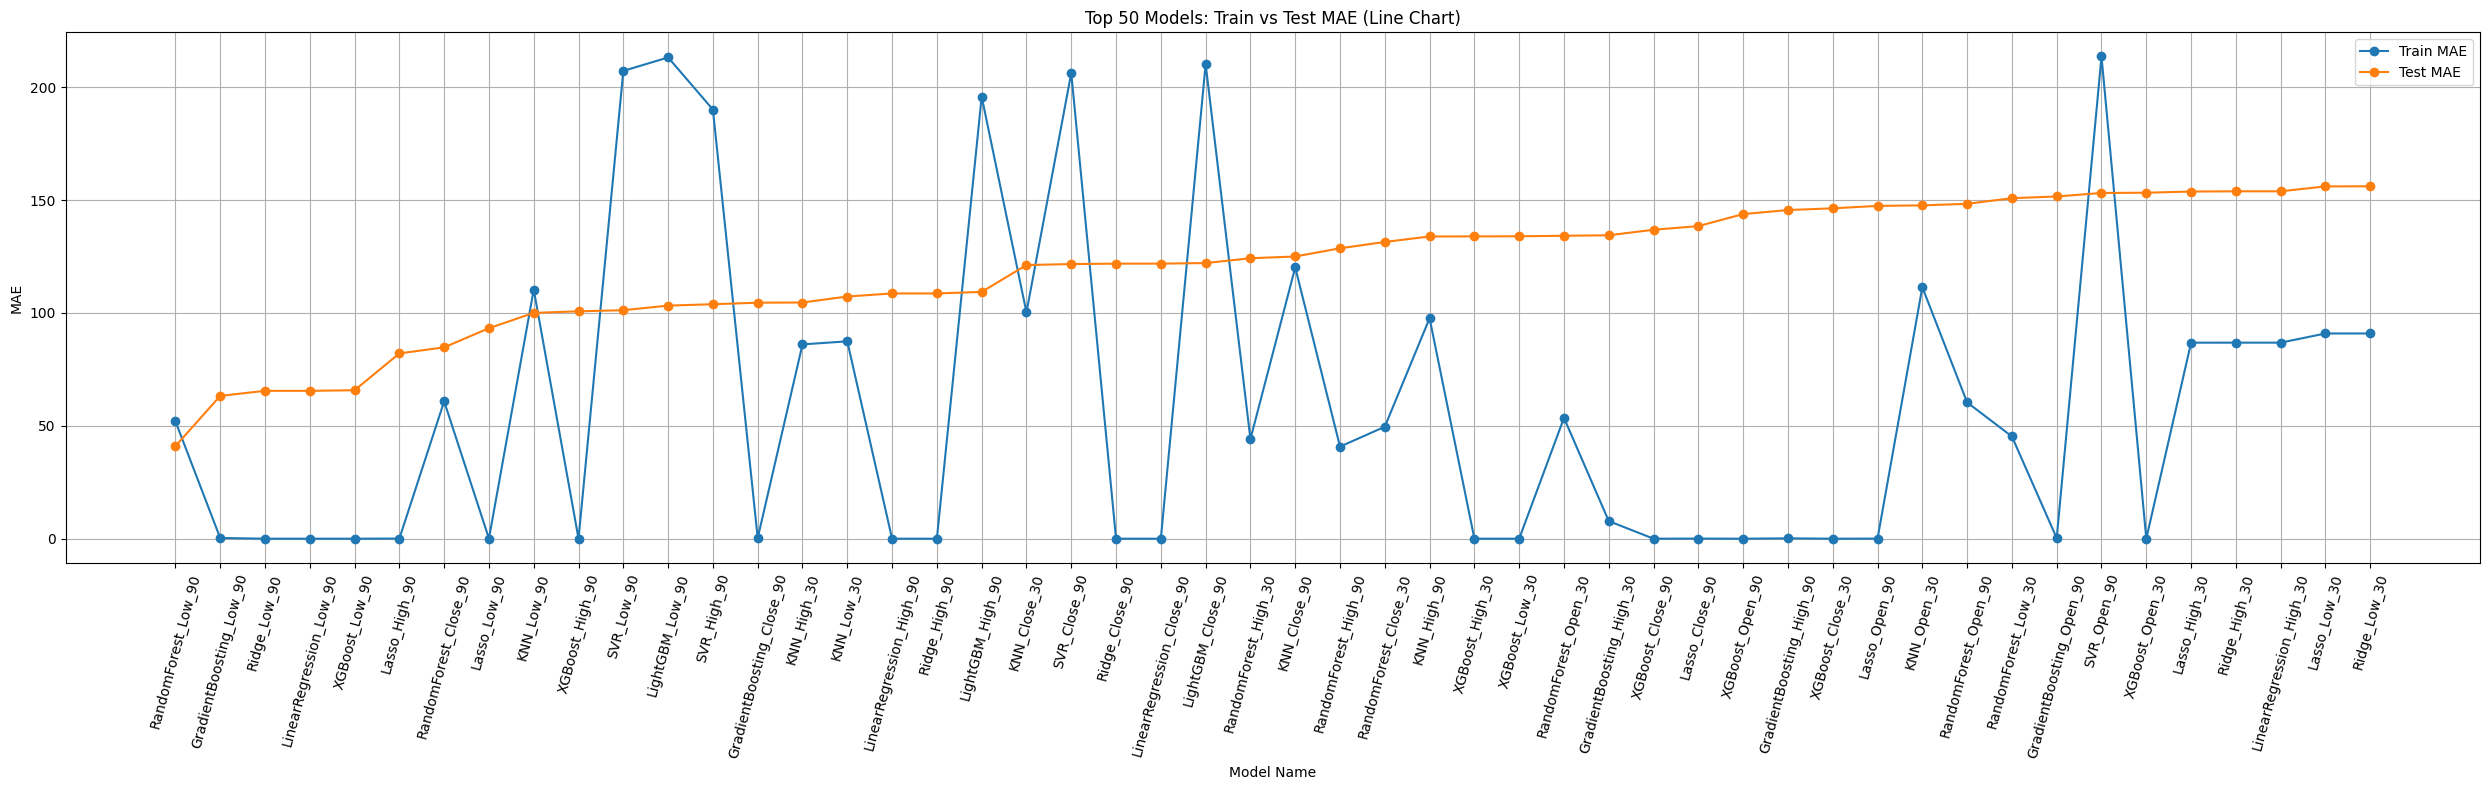

In [47]:
import matplotlib.pyplot as plt

if not results_df.empty:
    top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)

    plt.figure(figsize=(25, 8))
    plt.plot(top_50['Model'], top_50['train_mae'], marker='o', label='Train MAE')

    plt.plot(top_50['Model'], top_50['test_mae'], marker='o', label='Test MAE')

    plt.xticks(rotation=75)
    plt.xlabel('Model Name')
    plt.ylabel('MAE')
    plt.title('Top 50 Models: Train vs Test MAE (Line Chart)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("results_df is empty. Cannot plot.")

### 8. Relation btw. No of Input Days and Model Performance

1. **Extract Time Windows**
   - From each model name in `top_50`  
   - Split string by `_` → take last part (time window)  

2. **Count Frequencies**
   - `value_counts()` → count models per time window  
   - Sort by count (descending)  

3. **Plot Bar Chart**
   - X-axis: time windows  
   - Y-axis: number of models in Top 50  

4. **Customize**
   - Add labels (x, y), title  
   - Grid only on Y-axis for readability  
   - `tight_layout()` → clean layout  

5. **Show Chart**
   - `plt.show()` → display bar chart of time-window frequencies  

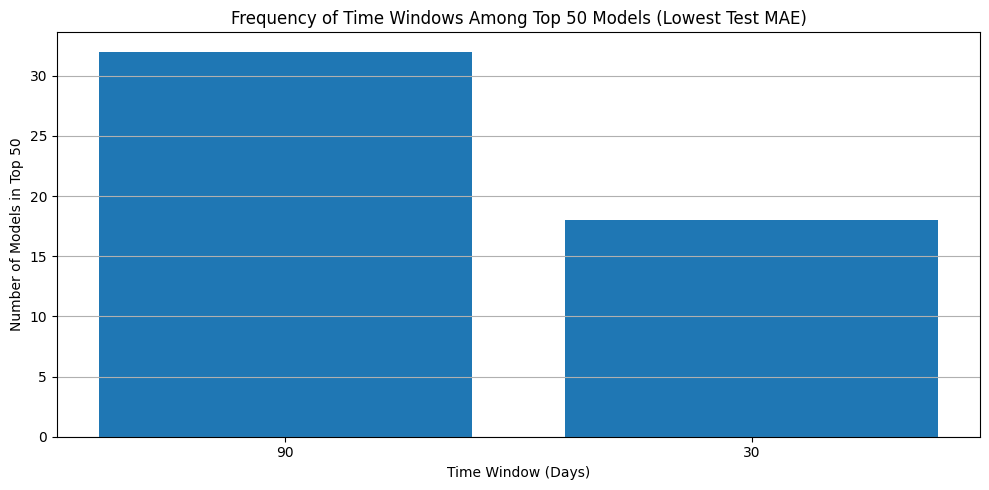

In [48]:
import matplotlib.pyplot as plt

if not results_df.empty:
    top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
    time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
    time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(time_counts.index, time_counts.values)

    # Labels and aesthetics
    plt.xlabel('Time Window (Days)')
    plt.ylabel('Number of Models in Top 50')
    plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("results_df is empty. Cannot plot.")

In [55]:
if not results_df.empty:
    # Filter models with a 60-day time window
    models_60_days = results_df[results_df['Model'].str.contains('_60')]

    # Display the Model and test_mae for these models
    display(models_60_days[['Model', 'test_mae']].sort_values(by='test_mae'))
else:
    print("results_df is empty. Cannot display models with time window 60.")

,Model,test_mae
58,KNN_Close_60,162.538571
97,KNN_High_60,182.677143
138,LightGBM_Low_60,189.451682
136,KNN_Low_60,200.682857
95,GradientBoosting_High_60,200.956517
99,LightGBM_High_60,208.777733
133,RandomForest_Low_60,209.757214
94,RandomForest_High_60,212.960643
98,XGBoost_High_60,215.081864
21,LightGBM_Open_60,226.914261


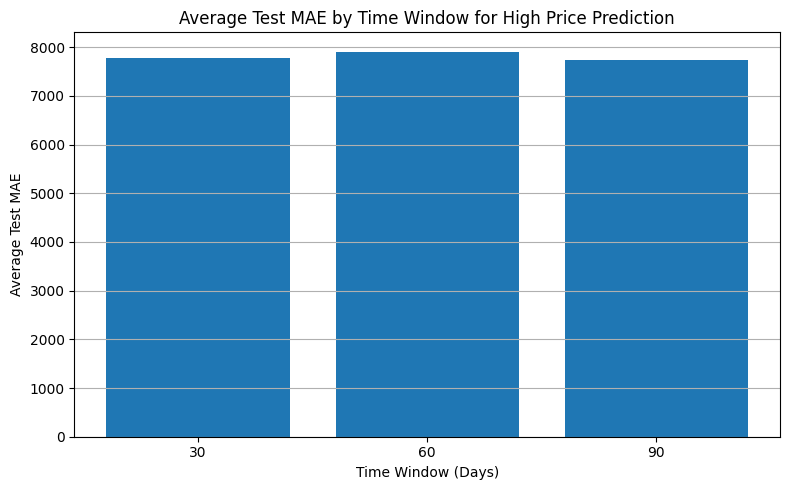

In [59]:
import matplotlib.pyplot as plt

if not results_df.empty:
    # Filter models predicting the 'High' price with 30, 60, or 90-day time windows
    filtered_results_high = results_df[results_df['Model'].str.contains('_High_') & results_df['Model'].str.contains('_30|_60|_90')].copy()

    # Extract time window and convert to numeric
    filtered_results_high['Time_Window'] = filtered_results_high['Model'].apply(lambda x: int(x.split('_')[-1]))

    # Calculate the average test_mae for each time window
    average_mae_by_time_window = filtered_results_high.groupby('Time_Window')['test_mae'].mean().sort_index()

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(average_mae_by_time_window.index.astype(str), average_mae_by_time_window.values)

    # Labels and aesthetics
    plt.xlabel('Time Window (Days)')
    plt.ylabel('Average Test MAE')
    plt.title('Average Test MAE by Time Window for High Price Prediction')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("results_df is empty. Cannot plot.")

### 9. Which column(HIGH/LOW/CLOSE/OPEN) should be taken into considration for model building?

1. **Select Top 50 Models**
   - Sort by `test_mae` → best 50 models  

2. **Extract Target Column**
   - From model names → split by `_`  
   - Take second last part as target column name  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each target  
   - Sort by frequency (descending)  

4. **Plot Bar Chart**
   - X-axis: target column names  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add labels, title  
   - Grid on Y-axis for readability  
   - Use `tight_layout()` to prevent label overlap  

6. **Show Chart**
   - `plt.show()` → display bar chart of target column frequencies

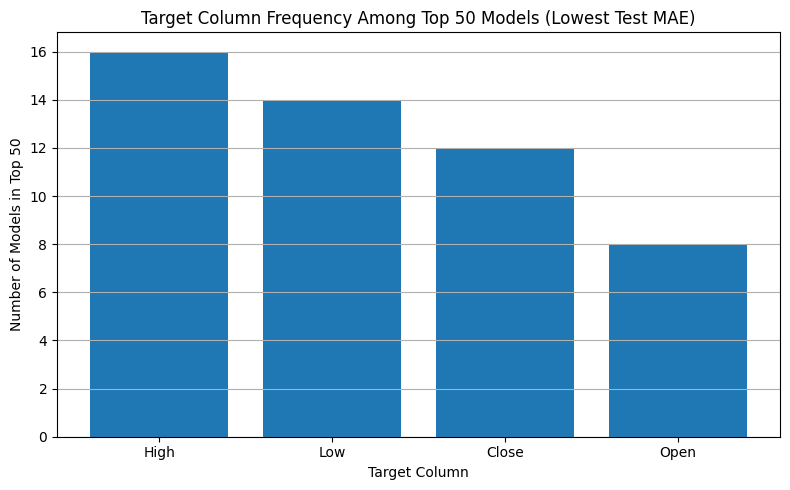

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract target columns from top 50 models
if not results_df.empty:
    top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
    target_columns = pd.Series([i.split('_')[-2] for i in top_50['Model']])
    target_counts = target_columns.value_counts().sort_values(ascending=False)  # Sort by count

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(target_counts.index, target_counts.values)

    # Labels and aesthetics
    plt.xlabel('Target Column')
    plt.ylabel('Number of Models in Top 50')
    plt.title('Target Column Frequency Among Top 50 Models (Lowest Test MAE)')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("results_df is empty. Cannot plot.")

### 10. Which model works in general better on this task?

1. **Select Top 50 Models**
   - Sort `results_df` by `test_mae`  
   - Keep best 50 models  

2. **Extract Model Types**
   - From model names → split by `_`  
   - Take the first part as model type (e.g., LinearRegression, LSTM)  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each model type  
   - Sort counts in descending order  

4. **Plot Bar Chart**
   - X-axis: model types  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add axis labels, title  
   - Grid only on Y-axis  
   - `tight_layout()` for spacing  

6. **Show Chart**
   - `plt.show()` → display bar chart of model type distribution  

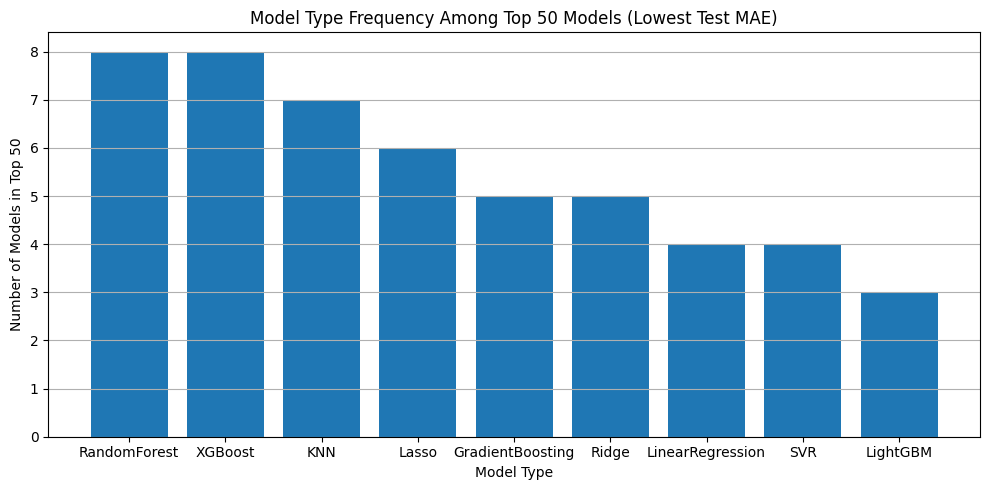

In [50]:
if not results_df.empty:
    top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
    model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
    model_counts = model_types.value_counts().sort_values(ascending=False)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(model_counts.index, model_counts.values)

    # Labels and aesthetics
    plt.xlabel('Model Type')
    plt.ylabel('Number of Models in Top 50')
    plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("results_df is empty. Cannot plot.")

### 11. Saving Models

1. **Save Results Table**
   - `results_df.to_csv('models.csv')` → save metrics as CSV  

2. **Save Trained Models**
   - `joblib.dump(trained_models, 'trained_models.joblib')`  
   - Stores all fitted ML + DL models + their metrics  

3. **Load Models**
   - `loaded_models = joblib.load('trained_models.joblib')`  
   - Reload models/metrics into memory for reuse  

In [51]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

### 12. Loading Saved Models

1. **Access Specific Model**
   - `loaded_models['KNN_High_90']`  
   - Retrieves dictionary with:
     - Trained model object  
     - Train/Test MAE & RMSE metrics  

2. **Extract Model**
   - `model = loaded_models['KNN_High_90']['model']`  
   - Assigns the trained KNN regressor to `model` variable  
   - Now can be used for `.predict()` on new data  

In [52]:
loaded_models['KNN_High_90']
model = loaded_models['KNN_High_90']['model']

### 13. Model Inference

1. **Inspect Input Sample**
   - `print(chunked_data['X_Open_90'][5])`  
   - Displays the 6th sample from feature set `X_Open_90`  

2. **Make Prediction**
   - `model.predict([chunked_data['X_Open_90'][5]])`  
   - Wrap sample in a list → ensures 2D shape `(1, n_features)`  
   - Outputs predicted value for that input using trained KNN model  

In [53]:
print(chunked_data['X_Open_90'][5])
print(model.predict([chunked_data['X_Open_90'][5]]))

[25935.1  26057.2  25901.2  25824.6  25546.85 25394.9  25181.95 25277.55
 25177.3  25167.65 25074.3  25079.75 25085.3  24916.55 24759.55 24620.55
 24691.95 24728.55 24818.55 25034.5  25108.75 25209.   25238.1  25410.2
 25441.05 25276.6  25073.6  25118.9  25074.45 24945.5  24991.   24864.1
 24802.6  24818.85 24980.75 24616.5  24653.   24432.7  24466.7  24695.8
 24899.5  24949.15 25064.15 25142.   24965.8  24891.35 24938.2  24607.25
 24586.2  24563.35 24371.5  24544.25 24464.2  24641.35 24720.25 24596.05
 24734.9  24642.25 24890.4  24609.65 24782.45 25010.35 25243.3  25139.35
 25166.65 24999.   25108.55 25230.75 25196.6  25089.5  25149.5  25255.5
 25511.65 25514.6  25427.85 25450.45 25428.85 25505.1  25588.3  25551.35
 25661.65 25576.65 25268.95 25150.35 25179.9  24939.75 24787.65 24803.25
 24788.35 24977.85]
[25017.52]



This notebook performs stock price prediction for the NIFTY 50 index, focusing on predicting the **High** price using various machine learning and deep learning models with different time windows. The key steps performed are:

1.  **Library and Dataset Import:** Necessary libraries for data handling, modeling, and evaluation are imported, and the NIFTY 50 data is loaded from a CSV file.
2.  **Data Preparation:** The data is prepared for time series prediction by creating sequences (chunks) of historical data (`X`) to predict a future value (`y`) for the 'Open', 'Close', 'High', and 'Low' columns, using specified time windows (30, 60, and 90 days).
3.  **Model Definition:** Functions are defined to build the architecture of the neural network models (RNN, LSTM, GRU, Bidirectional LSTM) with a dense layer for regression.
4.  **Model Definition (ML):** A list of traditional machine learning regressors (Linear Regression, Ridge, Lasso, RandomForest, GradientBoosting, SVR, KNN, XGBoost, LightGBM) is defined.
5.  **Model Training:** Both the machine learning and deep learning models are trained on the prepared data for each target column and time window. Deep learning models are trained for 50 epochs. The training process includes splitting the data into training and testing sets and evaluating the models using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). Models are skipped if there is insufficient data for a given time window.
6.  **Saving Model Statistics:** The evaluation metrics for all trained models are collected into a pandas DataFrame and saved to a CSV file (`models.csv`).
7.  **Model Visualization (Top 50):** The test MAE and train MAE for the top 50 models (based on test MAE) are visualized using a line plot to compare training and testing performance.
8.  **Visualization (Time Window Frequency):** A bar chart is generated to show the frequency of different time windows among the top 50 models.
9.  **Visualization (Target Column Frequency):** A bar chart is generated to show which target columns appear most frequently among the top 50 models.
10. **Visualization (Model Type Frequency):** A bar chart is generated to show the frequency of different model types among the top 50 models.
11. **Visualization (Test MAE by Time Window for High Price):** A bar plot shows the average test MAE for models predicting the 'High' price, grouped by time window (30, 60, and 90 days).
12. **Saving and Loading Models:** The trained models are saved to a joblib file (`trained_models.joblib`) and then loaded back into memory.
13. **Model Inference:** An example demonstrates how to load a specific trained model (KNN_High_90) and use it to make a prediction on a sample input.